In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.linear_model

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mno
from sklearn import linear_model
%matplotlib inline

In [3]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

y = train_data["Survived"]
features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
X_train = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

##  Missing values
### 1.1 Check missing values

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         714 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    uint8  
 6   Sex_male    891 non-null    uint8  
 7   Embarked_C  891 non-null    uint8  
 8   Embarked_Q  891 non-null    uint8  
 9   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 39.3 KB


In [5]:
X_train.isnull().sum()

Pclass          0
Age           177
SibSp           0
Parch           0
Fare            0
Sex_female      0
Sex_male        0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64

In [6]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Age         332 non-null    float64
 2   SibSp       418 non-null    int64  
 3   Parch       418 non-null    int64  
 4   Fare        417 non-null    float64
 5   Sex_female  418 non-null    uint8  
 6   Sex_male    418 non-null    uint8  
 7   Embarked_C  418 non-null    uint8  
 8   Embarked_Q  418 non-null    uint8  
 9   Embarked_S  418 non-null    uint8  
dtypes: float64(2), int64(3), uint8(5)
memory usage: 18.5 KB


In [7]:
X_test.isnull().sum()

Pclass         0
Age           86
SibSp          0
Parch          0
Fare           1
Sex_female     0
Sex_male       0
Embarked_C     0
Embarked_Q     0
Embarked_S     0
dtype: int64

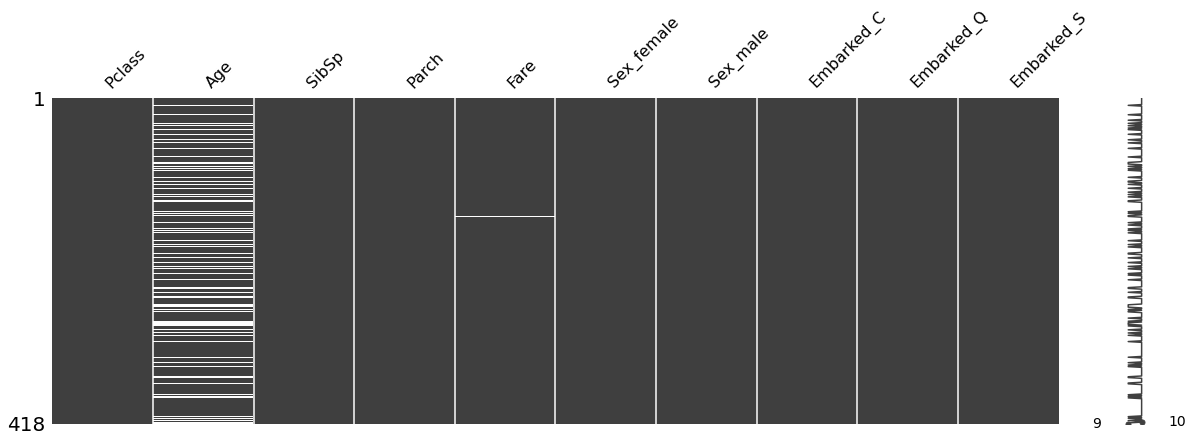

In [8]:
mno.matrix(X_test, figsize = (20, 6))  # Realizing the missingness

### 1.2 Filling Missing values use SLR

In [9]:
X_concat = pd.concat([X_train, X_test])

In [10]:
missing_columns = ["Age", "Fare"]

In [11]:
def random_imputation(df, feature):

    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    
    return df

In [12]:
for feature in missing_columns:
    X_concat[feature + '_imp'] = X_concat[feature]
    X_concat = random_imputation(X_concat, feature)
    
X_concat.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_imp,Fare_imp
0,3,22.0,1,0,7.2500,0,1,0,0,1,22.0,7.2500
1,1,38.0,1,0,71.2833,1,0,1,0,0,38.0,71.2833
2,3,26.0,0,0,7.9250,1,0,0,0,1,26.0,7.9250
3,1,35.0,1,0,53.1000,1,0,0,0,1,35.0,53.1000
4,3,35.0,0,0,8.0500,0,1,0,0,1,35.0,8.0500


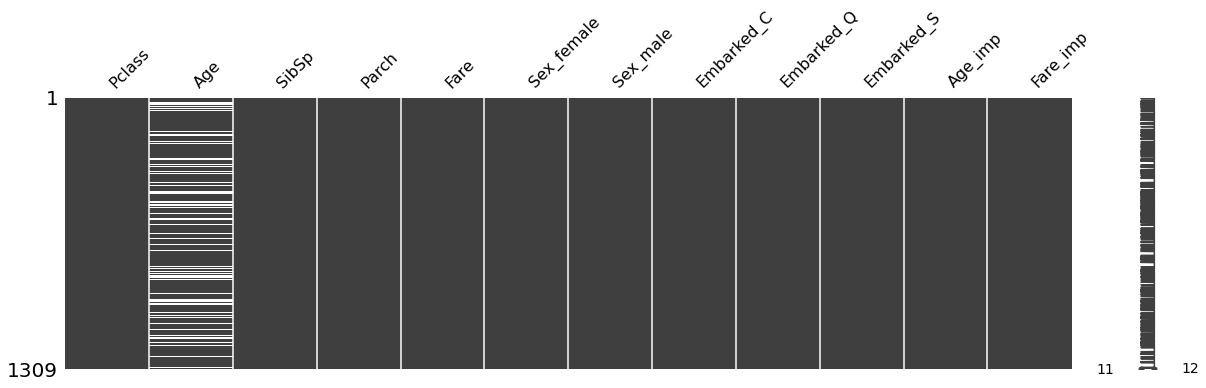

In [13]:
mno.matrix(X_concat, figsize = (20,5))

In [14]:
# deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

# for feature in missing_columns:
        
#     deter_data["Det" + feature] = df[feature + "_imp"]
#     parameters = list(set(df.columns) - set(missing_columns) - {feature + '_imp'})
    
#     #Create a Linear Regression model to estimate the missing data
#     model = linear_model.LinearRegression()
#     model.fit(X = df[parameters], y = df[feature + '_imp'])
    
#     #observe that I preserve the index of the missing data from the original dataframe
#     deter_data.loc[df[feature].isnull(), "Det" + feature] = model.predict(df[parameters])[df[feature].isnull()]

In [15]:
random_data = pd.DataFrame(columns = ["Ran" + name for name in missing_columns])

for feature in missing_columns:
        
    random_data["Ran" + feature] = X_concat[feature + '_imp']
    parameters = list(set(X_concat.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = X_concat[parameters], y = X_concat[feature + '_imp'])
    
    # Standard Error of the regression estimates is equal to std() of the errors of each estimates
    predict = model.predict(X_concat[parameters])
    std_error = (predict[X_concat[feature].notnull()] - X_concat.loc[X_concat[feature].notnull(), feature + '_imp']).std()
    
    # observe that I preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = X_concat[feature].shape[0], 
                                      loc = predict, 
                                      scale = std_error)
    random_data.loc[(X_concat[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(X_concat[feature].isnull()) & (random_predict > 0)]

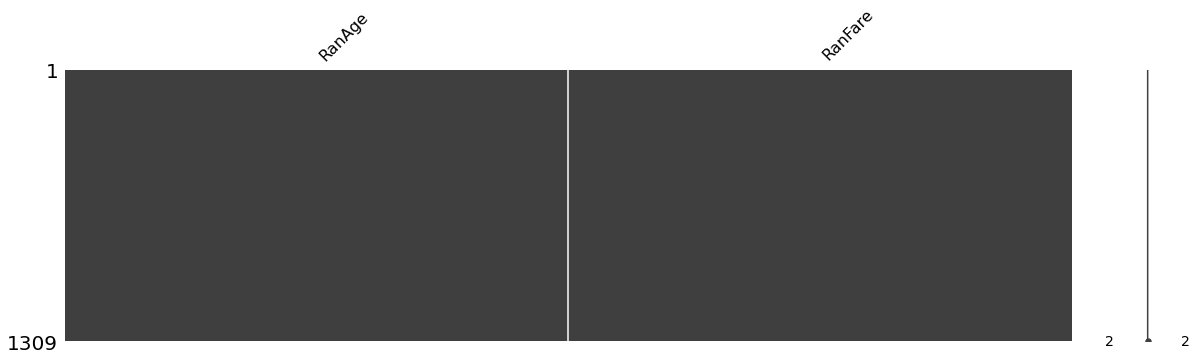

In [16]:
mno.matrix(random_data, figsize = (20,5))

In [17]:
X_train["Age"] = random_data["RanAge"][:891]
X_test["Age"] = random_data["RanAge"][891:]
X_test["Fare"] = random_data["RanFare"][891:]

## Logistic Regression

In [18]:
y_train = y[:666]
y_test = y[666:]
X_train_train = X_train[:666]
X_train_test = X_train[666:]

lg = sklearn.linear_model.LogisticRegressionCV()
lg.fit(X_train_train, y_train)

lg_predictions_train = lg.predict(X_train_train)
lg_predictions_test = lg.predict(X_train_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [19]:
print ('Accuracy of logistic regression in training set: %d ' % float((np.dot(y_train, lg_predictions_train) + 
                                                                       np.dot(1 - y_train,1 - lg_predictions_train)) / float(y_train.size) * 100) +
       '% ' + "(percentage of correctly labelled datapoints)" '\n' 
       'Accuracy of logistic regression in test set: %d ' % float((np.dot(y_test, lg_predictions_test) + 
                                                                   np.dot(1 - y_test,1 - lg_predictions_test)) / float(y_test.size) * 100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression in training set: 79 % (percentage of correctly labelled datapoints)
Accuracy of logistic regression in test set: 83 % (percentage of correctly labelled datapoints)


In [20]:
lg = sklearn.linear_model.LogisticRegressionCV()
lg.fit(X_train, y)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegressionCV()

In [21]:
pre2 = lg.predict(X_test)
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pre2})
output.to_csv('mos_logi2.csv', index = False)

## Shallow NN
LINEAR-> TANH -> LINEAR -> SIGMOID model

In [22]:
X_nn = X_train.values.T
y_nn = y.values.reshape(891,1).T
X_nn.shape, y_nn.shape

((10, 891), (1, 891))

In [23]:
def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """

    n_x = X.shape[0] 
    n_h = 4
    n_y = Y.shape[0]

    return (n_x, n_h, n_y)

In [24]:
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(221)
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [25]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [26]:
def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [27]:
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    logprobs = np.multiply(np.log(A2), Y)  + np.multiply(1 - Y, np.log(1 - A2))
    cost = - np.sum(logprobs) / m
    
    cost = float(np.squeeze(cost))  
    
    assert(isinstance(cost, float))
    
    return cost

In [28]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    W1 = parameters["W1"]
    W2 = parameters["W2"]
        
    # Retrieve also A1 and A2 from dictionary "cache".
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis = 1, keepdims = True) / m
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis = 1, keepdims = True) / m
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [29]:
def update_parameters(parameters, grads, learning_rate = 0.1):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Retrieve each gradient from the dictionary "grads"
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    # Update rule for each parameter
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [30]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost = False): 
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [31]:
def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > 0.5
    
    return predictions

In [32]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X_nn, y_nn, n_h = 4, num_iterations = 4000, print_cost=True)

Cost after iteration 0: 0.693406
Cost after iteration 1000: 0.578962
Cost after iteration 2000: 0.572593
Cost after iteration 3000: 0.663402


In [33]:
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    parameters = nn_model(X_nn, y_nn, n_h, num_iterations = 4000)
    predictions = predict(parameters, X_nn)
    accuracy = float((np.dot(y_nn,predictions.T) + np.dot(1 - y_nn,1 - predictions.T)) / float(y_nn.size) * 100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 1 hidden units: 61.61616161616161 %
Accuracy for 2 hidden units: 61.61616161616161 %
Accuracy for 3 hidden units: 72.61503928170595 %
Accuracy for 4 hidden units: 72.16610549943884 %
Accuracy for 5 hidden units: 62.96296296296296 %
Accuracy for 20 hidden units: 61.61616161616161 %
Accuracy for 50 hidden units: 69.1358024691358 %


### References

[Missing Data Imputation using Regression](https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression)